## Gerekli Kütüphaneler

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Örnek resim alalım

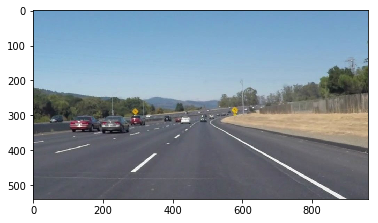

In [22]:
image=mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(image)

### Görüntüye karmaşık teknikler uygulamak için görüntüyü gri tonlamaya dönüştürmemiz gerekir . Bunu çeşitli olası nedenlerden dolayı yapıyoruz:

* Bunu yaparak görüntüyü 3B yerine 1D olduğundan karmaşıklığı azaltıyoruz. Bu, kenar algılama özelliğini çok daha kolay bir şekilde gerçekleştirmemizi sağlar.
* Gri tonlamalı görüntülerin RGB görüntüden 3 kat daha hızlı olduğuna inanıyorum

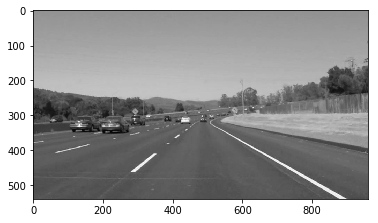

In [23]:
img_gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
cv2.imwrite('grayscale_image.jpg', img_gray)
plt.imshow(img_gray,cmap='gray')

# **Canny Kenar Tespiti**
Bu konuda önemli adımlar:

* Gauss bulanıklaştırma: - Canny Edge algılamasını gerçekleştirmeden önce, gürültüyü kaldırarak görüntüyü düzeltmemiz gerekir. Bu Gauss'un bulanıklaşması ile yapılır. cv2.GaussianBlur () işi yapan işlevdir.
* cv2.Canny () daha sonra kenar gradyanı gerçekleştirerek kenarlarını saptamak işlev gören ve kenar ve hangi bölümünün minimum ve maximun eşik değerlerine dayanmamaktadır olan görüntü parçası karar verir. Minimum ve maksimum eşik değerinin 1: 2 veya 1: 3 olarak tutulması doğru sonuç verir.
### Gri tonlamalı görüntüde Canny Edge Detection uygulandıktan sonraki sonuç aşağıdadır:

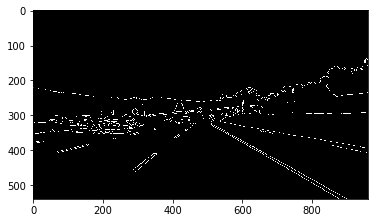

In [24]:
kernel_size = 5 #  kernel size for Gaussian smoothing
blur_gray = cv2.GaussianBlur(img_gray,(kernel_size, kernel_size),0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
cv2.imwrite('edges.jpg', edges)
plt.imshow(edges,cmap='gray')

In [25]:
print(edges.shape)

(540, 960)


### Arabadaki kameranın aynı konumda olduğu ve bu nedenle şerit çizgilerinin aynı bölgede olacağı açıktır. Böylece istenmeyen kenarları kaldırmak için görüntüye ROI (İlgi Bölgesi) uygulayabiliriz. Bu, şerit çizgilerini tanımlamak için gerekli olmadığından diğer kenarları kaldıran bir sonraki adımdır. Resmime ROI uyguladıktan sonraki sonuç aşağıdadır:

In [26]:
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

#We are going to mask the region where we expect our lane lines
    
vertices = np.array([[(170,539),(840,539),(560,340),(400,350)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color) 
masked_edges = cv2.bitwise_and(edges, mask)
cv2.imwrite('wanted_edges.jpg',masked_edges)

True

### Elde edilen görüntüden, şerit çizgilerini tanımlamamız gerekir. Bu, Hough Line Transformation yardımı ile yapılır.

# **Hough Hattı Dönüşümü**
### Hough transorm, bu şeklin herhangi bir matematiksel formül şeklinde gösterilip temsil edilemeyeceğini belirlemek için kullanılır. Hough çizgi dönüşümü, çizginin aşağıdaki gibi gösterilebileceği şekilde çizgiyi tespit eden bir örnektir:

### y = mx + c

### Bu projede kullandığım dönüşüm, Hough Transform'un optimize edilmiş versiyonu olan Probabilistic Hough Line Transform. Tüm puanları almak yerine, satır tespiti için yeterli olan bazı rastgele noktaları alır. cv2.HoughLinesP () aynı şeyi yapan fonksiyondur.

### Bu işlev, çizgi çizmek için kullanılabilecek (x, y) nokta kümesini döndürür. Bu işlevin aldığı önemli argümanlar:

### **min_line_length** : bir çizgi olarak kabul edilebileceği minimum uzunluk. Bundan daha kısa çizgiler ihmal edilir.
### **max_line_gap** : Sonradan boşluk olarak kabul edilebilecek maksimum boşluk.
### **threshold** : Bu eşik, her çizginin çizgi olarak kabul edilmesi için aldığı minimum oy sayısıdır.
### **Rho** : mesafe çözünürlüğü
### **theta** : radyan cinsinden açısal çözünürlük
### (X, y) noktaları topladıktan sonra, cv2.line () işlevini kullanarak kolayca çizgi çekebiliriz. Sonuçta ortaya çıkan görüntünün Hough Transform'a bakması şöyle:

In [27]:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes 
min_line_length = 5 #minimum number of pixels for considering it a line
max_line_gap = 10 #max gap till which we can consider it a line

line_image = np.copy(image)*0 # creating a blank to draw lines on

# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

# Iterated on the above output to draw lines on blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)


color_edges = np.dstack((edges, edges, edges)) 
   
lines_edges = cv2.addWeighted(image, 0.8, line_image,1, 0)

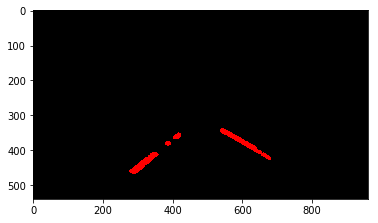

In [28]:
plt.imshow(line_image);

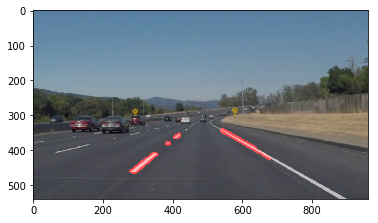

In [29]:
plt.imshow(lines_edges);

### Şimdi son bölüm çizgiyi tahmin etmektir. Bir çizgi şöyle gösterilebilir:

### y = mx + c

### Şimdi tespit edilen tüm şerit çizgilerini (x, y) alacağız ve bunların yardımıyla, ortalama x ve y koordinatını hesaplayacağız.

### Şimdi eğimi (m) (yc) / x olarak hesaplayın . M bilinen olduğu için, son çizginin altında gösterildiği gibi şerit çizgilerini kolayca uzatabiliriz:

In [30]:
y=350
y_size=image.shape[0]
x_size=image.shape[1]
new_line1=np.polyfit([480, 300], [480, 300],1)
x_values=[]
y_values=[]
x_left=[]
y_left=[]
x_right=[]
y_right=[]

x_points = []
y_points = []

for line in lines:
    for x1,y1,x2,y2 in line:
        x_points.append(x1)
        y_points.append(y1)
        x_points.append(x2)
        y_points.append(y2)
    
for line in lines:
    for x1,y1,x2,y2 in line:
        if x1 < 490 and x2 < 490 :
            x_left.append(x1)
            y_left.append(y1)
            x_left.append(x2)
            y_left.append(y2)
        elif x1 > 490 and x2 > 490:
            x_right.append(x1)
            y_right.append(y1)
            x_right.append(x2)
            y_right.append(y2)
    
right_pl_fit = np.polyfit(x_right, y_right,1)
left_pl_fit = np.polyfit(x_left, y_left,1)
m_left = left_pl_fit[0]
b_left = left_pl_fit[1]
minleft_x = min(x_left)
maxleft_x = max(x_left)
minleft_y = m_left*minleft_x + b_left # y = mx + c
maxleft_y = m_left*maxleft_x + b_left # y = mx + c
max_left_below_y=image.shape[0]
max_left_below_x=(max_left_below_y-b_left)/m_left
    
# Draw line for left lane using equation y = mx + c
cv2.line(line_image,(int(max_left_below_x),int(max_left_below_y)), (int(maxleft_x), int(maxleft_y)), color=[255,0,0],thickness=8)

m_right = right_pl_fit[0]
b_right = right_pl_fit[1]

min_right_y=max(y_right)

minright_x = min(x_right)
maxright_x = max(x_right)

minright_y = m_right*minright_x + b_right # y = mx + c
maxright_y = m_right*maxright_x + b_right # y = mx + c
max_right_below_y=image.shape[0]
max_right_below_x=(max_right_below_y-b_right)/m_right
    
    # Draw line for left lane using equation y = mx + c

cv2.line(line_image, (int(max_right_below_x),int(max_right_below_y)), (int(minright_x),int(minright_y)), color=[255,0,0],thickness=15) 
a=np.bitwise_or(line_image,image)

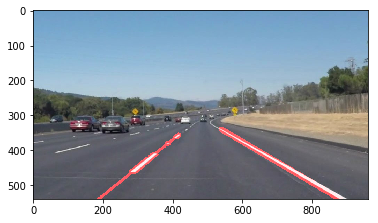

In [31]:
plt.imshow(np.bitwise_or(a,line_image))

# **Videoda deneyelim**
## Tüm işlemleri bir metod içinde gerçekleştirelim

In [32]:
def process_image(image):
    
    image_cp=np.copy(image)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)


    kernel_size = 5 #  kernel size for Gaussian smoothing
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

#We are going to mask the region where we expect our lane lines
    
    vertices = np.array([[(170,539),(840,539),(560,340),(400,350)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color) 
    masked_edges = cv2.bitwise_and(edges, mask)


    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes 
    min_line_length = 5 #minimum number of pixels for considering it a line
    max_line_gap = 10 #max gap till which we can consider it a line

    line_image = np.copy(image)*0 # creating a blank to draw lines on

# Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

# Iterated on the above output to draw lines on blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)


    color_edges = np.dstack((edges, edges, edges)) 
   

    lines_edges = cv2.addWeighted(image_cp, 0.8, line_image,1, 0) #this is to draw lines on edged image
    
    line_image1=np.copy(line_image)
    
    y=350
    y_size=image.shape[0]
    x_size=image.shape[1]
    new_line1=np.polyfit([480, 300], [480, 300],1)
    x_values=[]
    y_values=[]
    x_left=[]
    y_left=[]
    x_right=[]
    y_right=[]

    x_points = []
    y_points = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            x_points.append(x1)
            y_points.append(y1)
            x_points.append(x2)
            y_points.append(y2)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 < 490 and x2 < 490 :
                x_left.append(x1)
                y_left.append(y1)
                x_left.append(x2)
                y_left.append(y2)
            elif x1 > 490 and x2 > 490:
                x_right.append(x1)
                y_right.append(y1)
                x_right.append(x2)
                y_right.append(y2)
    
    right_pl_fit = np.polyfit(x_right, y_right,1)
    left_pl_fit = np.polyfit(x_left, y_left,1)
    m_left = left_pl_fit[0]
    b_left = left_pl_fit[1]
    minleft_x = min(x_left)
    maxleft_x = max(x_left)
    minleft_y = m_left*minleft_x + b_left # y = mx + c
    maxleft_y = m_left*maxleft_x + b_left # y = mx + c
    max_left_below_y=image.shape[0]
    max_left_below_x=(max_left_below_y-b_left)/m_left
    
    # Draw line for left lane using equation y = mx + c
    cv2.line(line_image1,(int(max_left_below_x),int(max_left_below_y)), (int(maxleft_x), int(maxleft_y)), color=[255,0,0],thickness=8)

    m_right = right_pl_fit[0]
    b_right = right_pl_fit[1]

    min_right_y=max(y_right)

    minright_x = min(x_right)
    maxright_x = max(x_right)

    minright_y = m_right*minright_x + b_right # y = mx + c
    maxright_y = m_right*maxright_x + b_right # y = mx + c
    max_right_below_y=image.shape[0]
    max_right_below_x=(max_right_below_y-b_right)/m_right
    
    # Draw line for left lane using equation y = mx + c

    cv2.line(line_image1, (int(max_right_below_x),int(max_right_below_y)), (int(minright_x),int(minright_y)), color=[255,0,0],thickness=15) 
    a=np.bitwise_or(line_image1,image)
    return a

In [36]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
clip = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [01:19<00:00,  8.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 22s


# Faydalı olması dileğiyle